## Libs

In [2]:
import os
import shap
import pickle
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgbm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils.general import viz_performance
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_validate, cross_val_score, KFold, train_test_split

warnings.filterwarnings('ignore')

## Constants

In [3]:
SEED = 1

## Data Ingestion

In [4]:
DATA_RAW_PATH = os.path.join('..','data','raw')
MODEL_PATH = os.path.join('..', 'models')
DATA_RAW_NAME = ['abono.csv', 'aposentados.csv']
DATA_IMG_PATH = os.path.join('..', 'figures')
DATA_INTER_PATH = os.path.join('..','data','interim')
DATA_PROCESSED_PATH = os.path.join('..','data','processed')
DATA_INTER_NAME = 'interim.csv'
DATA_PROCESSED_NAME = 'processed.csv'
MODEL_NAME = 'model.pkl'

In [5]:
df = pd.read_csv(os.path.join(DATA_PROCESSED_PATH, DATA_PROCESSED_NAME), sep='\t')

In [6]:
df.head(3)

,DSC_CARGO_EMPREGO,NV_ESCOLARIDADE,DN_ORGAO_ATUACAO,UF_UPAG,DN_UNIDADE_ORGANIZACIONAL,UF_RESIDENCIA,CIDADE_RESIDENCIA,SITUACAO_SVR,NM_ORGAO,SIGLA_ORGAO,CARGO,CLASSE,PADRAO,TP_APOSENTADORIA,OC_INGRESSO_SVP,CD_ORGAO,MES_ABONO_sin,RENDIMENTO_TOTAL
0,122.0,6.0,115.0,15.0,515.0,15.0,279.0,1.0,109.0,103.0,122.0,16.0,38.0,3.0,0.0,0,-2.449294e-16,1.0
1,5.0,5.0,115.0,6.0,40.0,6.0,179.0,1.0,109.0,103.0,5.0,16.0,37.0,3.0,0.0,0,8.660254e-01,0.0
2,5.0,5.0,115.0,6.0,42.0,6.0,179.0,1.0,109.0,103.0,5.0,16.0,37.0,3.0,0.0,0,8.660254e-01,0.0


In [7]:
df.duplicated().sum()

0

## Modeling

In [8]:
df.RENDIMENTO_TOTAL.value_counts(normalize=True)

1.0    0.51538
0.0    0.48462
Name: RENDIMENTO_TOTAL, dtype: float64

In [9]:
train = df.drop('RENDIMENTO_TOTAL', axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train, df.RENDIMENTO_TOTAL,
                                                    test_size=.3,
                                                    random_state=SEED,
                                                    stratify=df.RENDIMENTO_TOTAL)

### Baseline

In [11]:
reglog = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    random_state=SEED
)

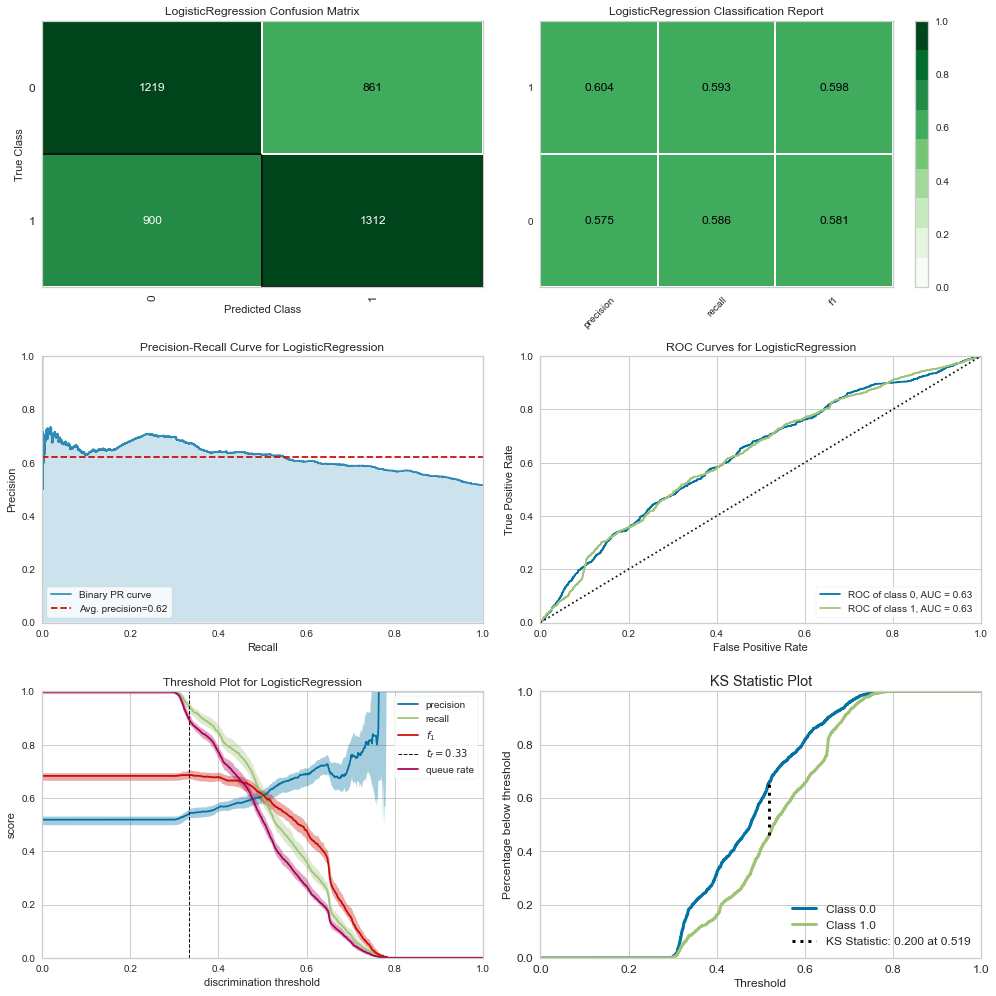

<Figure size 576x396 with 0 Axes>

In [12]:
viz_performance(X_train, X_test, y_train, y_test, reglog, ['0', '1'], figsize=(14,14))
plt.savefig(os.path.join(DATA_IMG_PATH,'baseline-reglog-metrics.png'), format='png')

### Models

In [13]:
models = [
          ('DecisionTree', DecisionTreeClassifier(random_state=SEED)),
          ('RandomForest', RandomForestClassifier(random_state=SEED)),
          ('ExtraTree', ExtraTreesClassifier(random_state=SEED)),
          ('Adaboost', AdaBoostClassifier(random_state=SEED)),
          ('XGBoost', xgb.XGBClassifier(random_state=SEED, verbosity=0)),
          ('LightGBM', lgbm.LGBMClassifier(random_state=SEED))
          ]

In [14]:
original = pd.DataFrame()

for name, model in tqdm(models):
    

    kfold = KFold(n_splits=5, random_state=SEED, shuffle=True)
    score = cross_validate(model, X_train, y_train, cv=kfold, scoring=['precision_weighted','recall_weighted','f1_weighted'], return_train_score=True)        
    additional = pd.DataFrame({
        'precision_train':np.mean(score['train_precision_weighted']),
        'precision_test':np.mean(score['test_precision_weighted']),
        'recall_train':np.mean(score['train_recall_weighted']),
        'recall_test':np.mean(score['test_recall_weighted']),
        'f1_train':np.mean(score['train_f1_weighted']),
        'f1_test':np.mean(score['test_f1_weighted']),
    }, index=[name])

    new = pd.concat([original, additional], axis=0)
    original = new

original

  0%|          | 0/6 [00:00<?, ?it/s]

,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
DecisionTree,0.980804,0.716246,0.980074,0.715839,0.980078,0.715878
RandomForest,0.980051,0.773188,0.980049,0.771573,0.980049,0.771585
ExtraTree,0.980804,0.768385,0.980074,0.767577,0.980078,0.767610
Adaboost,0.764477,0.757059,0.762435,0.754495,0.762370,0.754417
XGBoost,0.888781,0.790960,0.885038,0.786755,0.884947,0.786510
LightGBM,0.848673,0.797141,0.842514,0.791450,0.842190,0.791016


  0%|          | 0/6 [00:00<?, ?it/s]

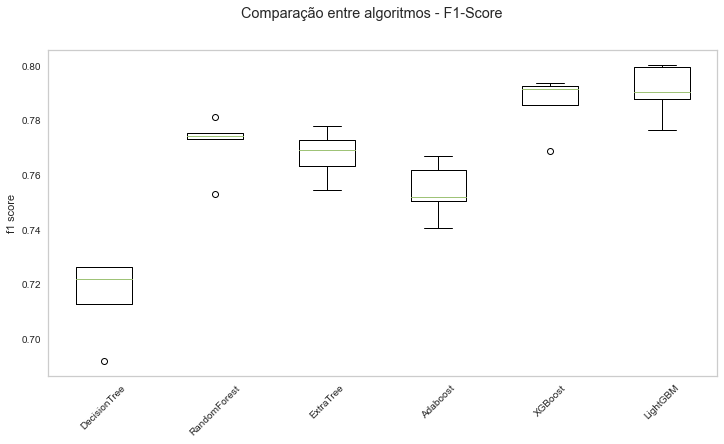

<Figure size 576x396 with 0 Axes>

In [15]:
results = []
names = []

for name, model in tqdm(models):
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=('f1_weighted'))
    results.append(cv_results)
    names.append(name)

fig = plt.figure(figsize=(12,6))
fig.suptitle('Comparação entre algoritmos - F1-Score')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('f1 score')
plt.xticks(rotation=45)
plt.grid(b=False)
plt.show()

plt.savefig(os.path.join(DATA_IMG_PATH,'models-score.png'), format='png')

### Selected Model

In [16]:
clf =  lgbm.LGBMClassifier(random_state=SEED, max_depth=5)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1760  320]
 [ 616 1596]]
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      2080
         1.0       0.83      0.72      0.77      2212

    accuracy                           0.78      4292
   macro avg       0.79      0.78      0.78      4292
weighted avg       0.79      0.78      0.78      4292



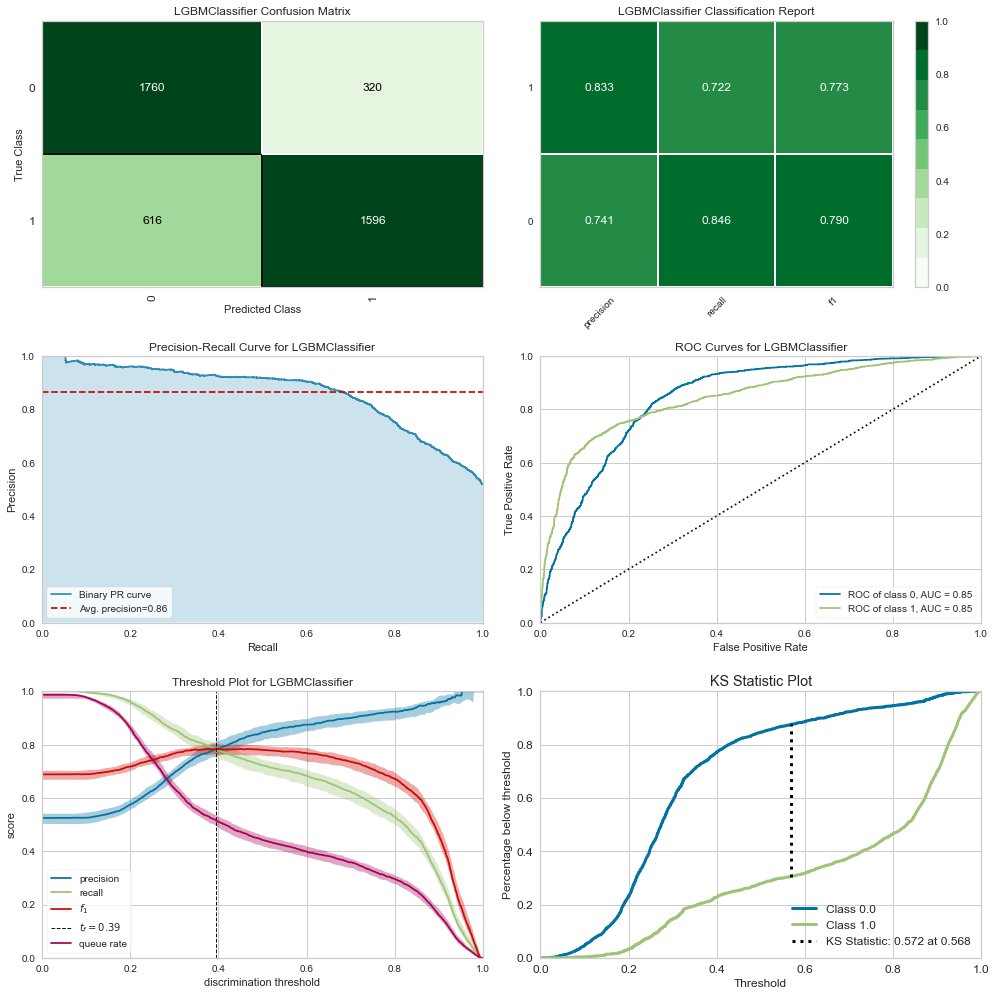

<Figure size 576x396 with 0 Axes>

In [17]:
viz_performance(X_train, X_test, y_train, y_test, clf, ['0', '1'], figsize=(14,14))
plt.savefig(os.path.join(DATA_IMG_PATH,'final-lgbm-metrics.png'), format='png')

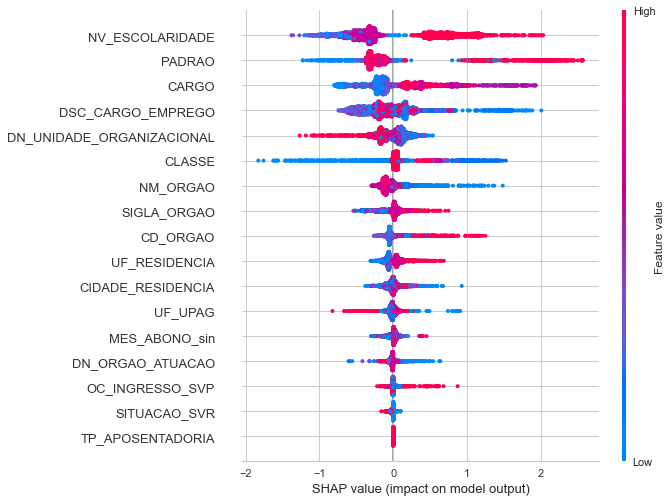

<Figure size 576x396 with 0 Axes>

In [18]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)
plt.savefig(os.path.join(DATA_IMG_PATH,'variable-performance.png'), format='png')

### Export Model

In [19]:
pickle.dump(clf, open(os.path.join(MODEL_PATH,MODEL_NAME), 'wb'))

## Conclusions

1. Base foi dividida em 30% para teste e 70% para treino do modelo;
2. Variável alvo estava balanceada com proporções de ~51.5% e 48.4%;
3. Baseline de uma Regressao Logista que mostrou baixa separação entre os *target*, tendo um modelo que pouco generalizava;
4. Selecionado alguns modelos para avaliar performaces;
5. Utilzado técnicas de *cross validate* com *k-fold* = 5;
6. Como métrica a ser avaliada foi escolhida o *f1-score*, porém, baseado no problema que queremos atacar poderiamos escolher uma outra métrica;
7. O modelo baseado em árvore foi selecionado (LigthGBM) por ter um f1-score mais alto no conjunto de teste;
8. Com um modelo baseado em árvore conseguimos bater o nosso *baseline* tendo uma melhor separação das variáveis de acordo com *KS Statistic*, um AUC de 85%. Poderiamos variar o *threshold* para otimizar *recall* ou *precision*;
9. As variáveis que possuem um maior poder de predição são: NV_ESCOLARIDADE, PADRAO e CARGO;
10. A variável CLASSE apesar de ter um poder de predição positivo, também dificultou na predição, chegando a ter um SHAP value de -2;

Obs.: Não houve tunagem de hiperparâmetros.